In [ ]:
%pip install WordCloud
%pip install yellowbrick
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import re
import nltk
import random
import string
import os
import pandas as pd
from wordcloud import WordCloud
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import wordnet
from yellowbrick.text import TSNEVisualizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix

need to download if you don't download it

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to C:\Users\nasse/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nasse/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\nasse/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nasse/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to C:\Users\nasse/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# preprocceing && prepareing Data

In [ ]:
# here to determine the type of word adj or verb or noun
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
def process_book(book_path, num_sentences=200, sentence_len=70):
    random.seed(5)
    # Read the text book
    with open(book_path, 'r', encoding='utf-8') as f:
        book = f.read()


    # remove all the empty lines
    book = re.sub(r'\n\s*\n', '\n', book)


    # tokenize the book
    tokens = nltk.word_tokenize(book)


    # lower case all the words
    tokens = [w.lower() for w in tokens]


    # remove stopwords from tokens
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [w for w in tokens if w not in stop_words]


    # remove punctuation from tokens
    table = str.maketrans('', '', string.punctuation)
    #tokens = [w.translate(table) for w in tokens]


    # remove remaining tokens that are not alphabetic
    tokens = [w for w in tokens if w.isalpha()]

    # perform lemmetization on the data
    lemmatizer = WordNetLemmatizer()
   # tokens = [lemmatizer.lemmatize(w) for w in tokens]
    tokens=[lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens]
    # get the author name
    author = re.search(r'Author: (.*)', book).group(1)


    # create random sentences from the tokens
    sentences = []
    for i in range(num_sentences):

        index = random.randint(0, len(tokens)-sentence_len)
        sentence = " ".join(tokens[index:index+sentence_len])
        sentences.append(sentence)


    # create a dataframe from the sentences associated with the author name as a label
    df = pd.DataFrame({'sentence': sentences, 'author': author})


    return df

loading & reading Books

In [ ]:
# define the folder path containing the books

#### here make sure change path to Flolder  BOOKS  in your OS  if you get error in path

folder_path ='.\BOOKS'

# create an empty dataframe to store the processed books
df_books_orginal = pd.DataFrame(columns=['sentence', 'author'])

# loop through all the files in the folder
for filename in os.listdir(folder_path):
    # check if the file is a text file
    print(filename)
    if filename.endswith('.txt'):
        # get the full path of the file
        file_path = os.path.join(folder_path, filename)
        # process the book and append the resulting dataframe to the main dataframe
        df_book = process_book(file_path)
        df_books_orginal = pd.concat([df_books_orginal, df_book], ignore_index=True)

# print the first few rows of the resulting dataframe



Crime and Punishment.txt
Dracula.txt
The Man Who Was Thursday.txt
The Moonstone.txt
The murder of Roger Ackroyd.txt


In [ ]:
df_books=df_books_orginal.copy()
df_books

,sentence,author
0,follow need money need understand give give be...,Fyodor Dostoevsky
1,first opportunity must refuse luzhin may never...,Fyodor Dostoevsky
2,ha way remember rodion romanovitch year ago da...,Fyodor Dostoevsky
3,destroy copy work possess physical medium disc...,Fyodor Dostoevsky
4,go porfiry sick rather go friend explosive lie...,Fyodor Dostoevsky
...,...,...
995,abruptly ackroyd burst shrill protest flora re...,Agatha Christie
996,stair reach top telephone rang hall mr bates s...,Agatha Christie
997,raglan shrug shoulder well miss ackroyd poirot...,Agatha Christie
998,association caroline lead preserve impassive c...,Agatha Christie


In [ ]:
# create a dictionary to map the distinct values to labels
label_author = {'Fyodor Dostoevsky': 'a', 'Wilkie CollinsBram Stoke': 'b', 'G. K. Chesterton': 'c', 'Agatha Christie': 'd', 'Bram Stoke': 'e'}
# we  need to copy the author culoum only
#bel_author = {"a":"a"}

# use the replace() method to map the distinct values to labels
df_books['label'] = df_books['author'].replace(label_author)

# display the resulting DataFrame
df_books

,sentence,author,label
0,follow need money need understand give give be...,Fyodor Dostoevsky,a
1,first opportunity must refuse luzhin may never...,Fyodor Dostoevsky,a
2,ha way remember rodion romanovitch year ago da...,Fyodor Dostoevsky,a
3,destroy copy work possess physical medium disc...,Fyodor Dostoevsky,a
4,go porfiry sick rather go friend explosive lie...,Fyodor Dostoevsky,a
...,...,...,...
995,abruptly ackroyd burst shrill protest flora re...,Agatha Christie,d
996,stair reach top telephone rang hall mr bates s...,Agatha Christie,d
997,raglan shrug shoulder well miss ackroyd poirot...,Agatha Christie,d
998,association caroline lead preserve impassive c...,Agatha Christie,d


In [ ]:
Author = list(df_books.author.unique())
Author_dic={}
for index ,name  in enumerate(Author):
    Author_dic[index] =name
Author_dic

{0: 'Fyodor Dostoevsky',
 1: 'Bram Stoker',
 2: 'G. K. Chesterton',
 3: 'Wilkie Collins',
 4: 'Agatha Christie'}

In [ ]:
# Reset the index of the shuffled DataFrame to start from 0 and drop the old index.
df_books = df_books.sample(frac=1).reset_index(drop=True)
df_books['label'] = pd.factorize(df_books['label'])[0]
df_books

,sentence,author,label
0,time sort thing say colonel melrose smile raym...,Agatha Christie,0
1,say secretary grimly plant foot foothold shall...,G. K. Chesterton,1
2,kind simple entertainment popular king abbot g...,Agatha Christie,0
3,part remark thank tell distinguish extraordina...,Fyodor Dostoevsky,2
4,penetration would see trace sentimentality som...,Fyodor Dostoevsky,2
...,...,...,...
995,something silent unexpected innocence left sym...,G. K. Chesterton,1
996,go gateway make think would sure home moment a...,Fyodor Dostoevsky,2
997,say gently lay hand quite sure truth want look...,Agatha Christie,0
998,grimly plant foot foothold shall find say syme...,G. K. Chesterton,1


In [ ]:
#################################################
##function to display all frequency
###########################################


def show_most_word_in_book(df_books,number_of_book=0,number_of_max_word=200,list_names=Author_dic):
    all_words = WordCloud(collocations=False,
                background_color="black",
                max_words=number_of_max_word,
                contour_color='steelblue',
                contour_width=16)

    # Generate a wordcloud
    print("Name of Author ",Author_dic.get(number_of_book))
    #print(df_books[df_books["author"]==number_of_book]["sentence"])
    all_words.generate(str(df_books[df_books['label']==number_of_book]['sentence']))

    # show
    #plt.figure(figsize=[20,10])
    plt.axis('off')
    plt.imshow(all_words)
    plt.legend(Author_dic.get(number_of_book))
    plt.imshow(all_words, cmap=None)

    plt.show()

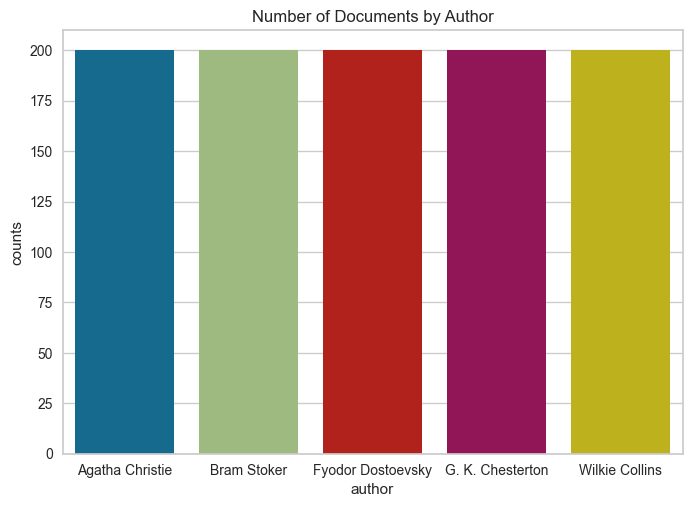

In [ ]:
# create a new DataFrame with the count of books by author
author_counts = df_books.groupby('author').size().reset_index(name='counts')

# plot the results using seaborn
ax = sns.barplot(x="author", y="counts", data=author_counts)

# rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# add title
plt.title('Number of Documents by Author')

# show the plot
plt.show()



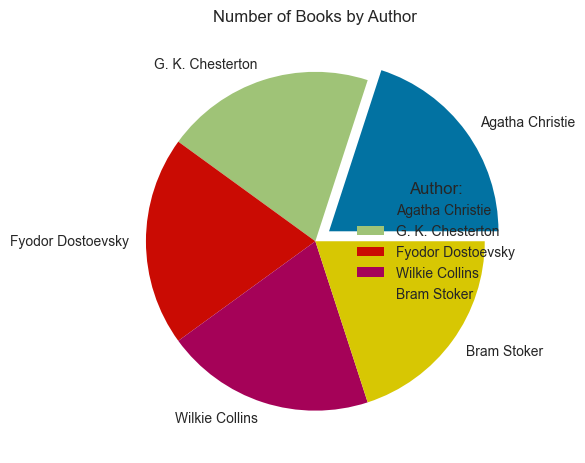

In [ ]:
# create a pie chart of book counts by author
df_books['author'].value_counts().plot.pie(explode = [0.1, 0, 0, 0,0])

# add a legend to the chart
plt.legend(title = 'Author:',loc='right')
# hide the y-axis label
plt.ylabel('')
# add title
plt.title('Number of Books by Author')
# show the chart
plt.show()

Text(0, 0.5, 'count')

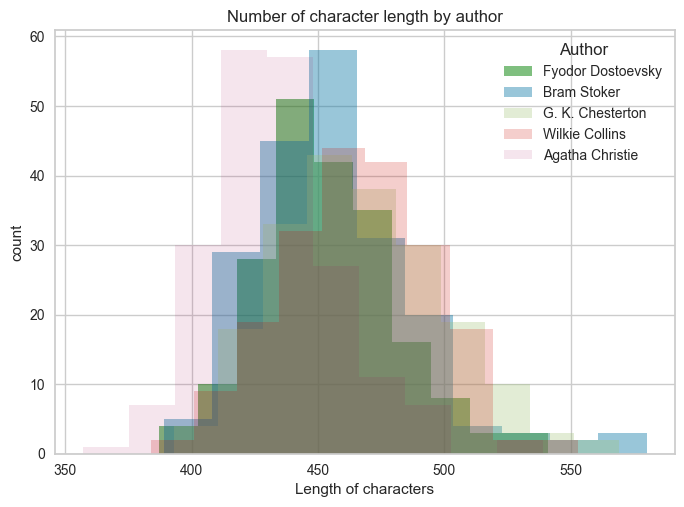

In [ ]:
df_books['char_length']=df_books['sentence'].apply(len)
df_books[df_books['label']==0]['char_length'].hist(label=df_books['label'],alpha=0.5,color=['green'] )
df_books[df_books['label']==1]['char_length'].hist(label=df_books['label'],alpha=0.4)
df_books[df_books['label']==2]['char_length'].hist(label=df_books['label'],alpha=0.3)
df_books[df_books['label']==3]['char_length'].hist(label=df_books['label'],alpha=0.2)
df_books[df_books['label']==4]['char_length'].hist(label=df_books['label'],alpha=0.1)
plt.legend([Author_dic.get(0),Author_dic.get(1),Author_dic.get(2),Author_dic.get(3),Author_dic.get(4)],title='Author')
plt.title('Number of character length by author')
plt.xlabel('Length of characters')
plt.ylabel('count')

Name of Author  Fyodor Dostoevsky


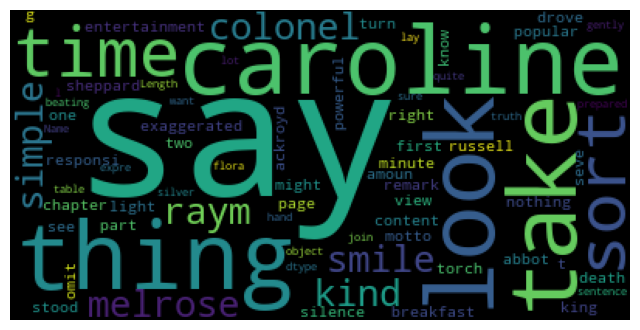

Name of Author  Bram Stoker


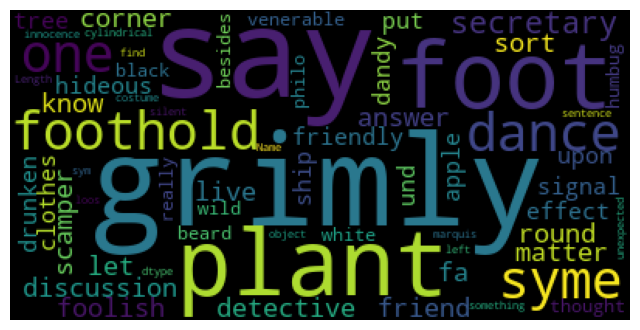

Name of Author  G. K. Chesterton


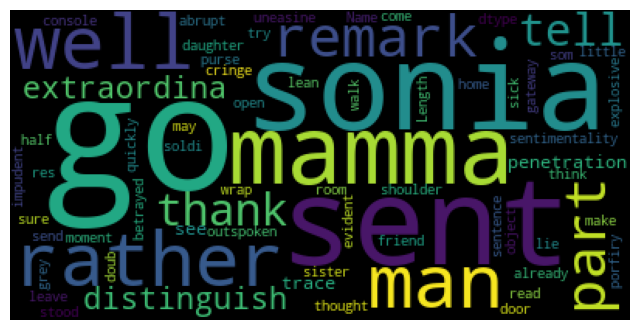

Name of Author  Wilkie Collins


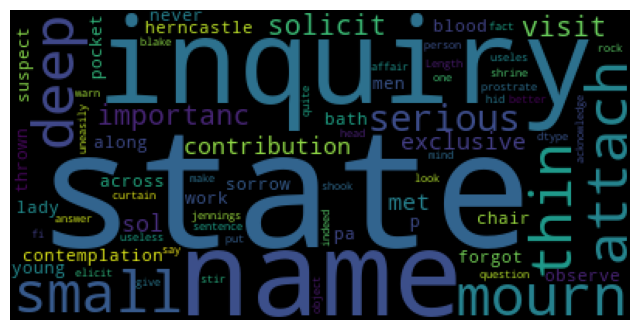

Name of Author  Agatha Christie


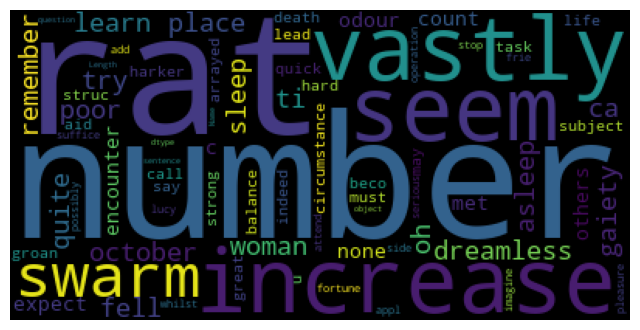

In [ ]:
for i in range (5):
 show_most_word_in_book(df_books,number_of_book=i,number_of_max_word=200)


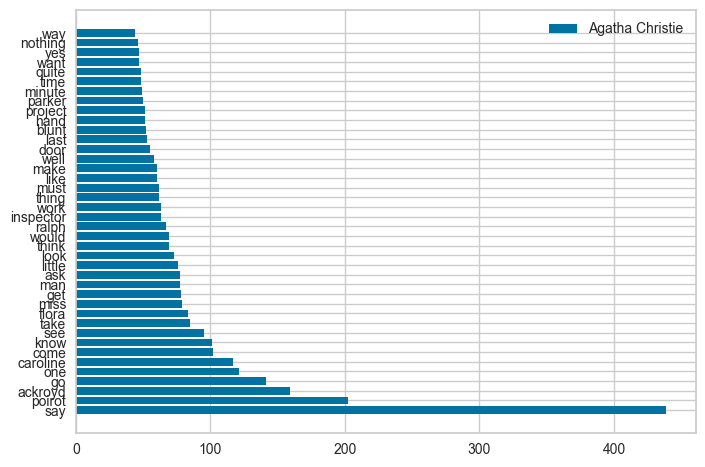

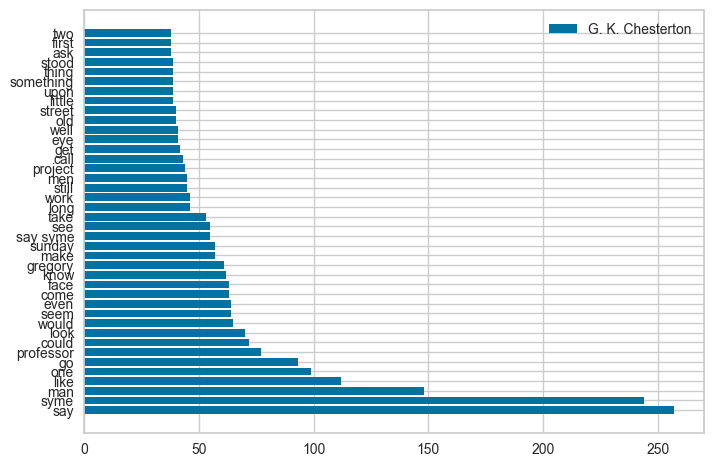

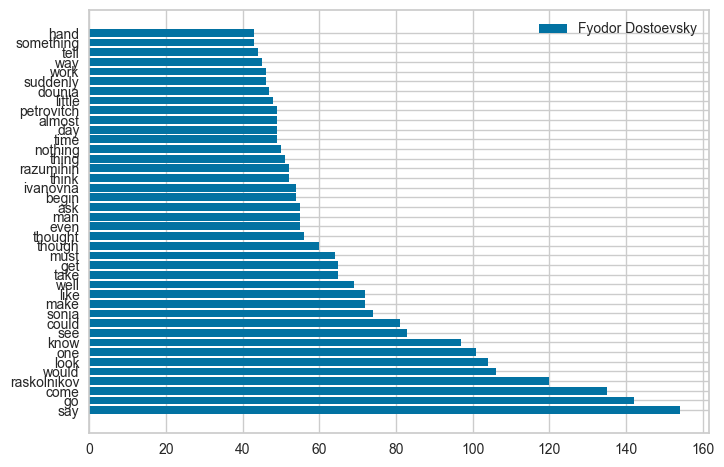

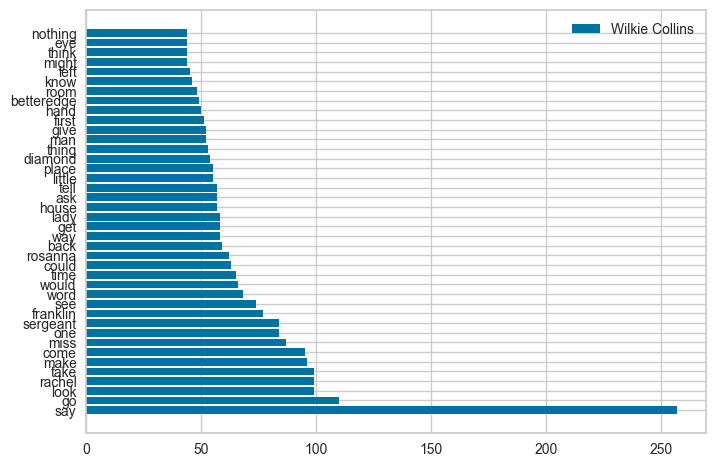

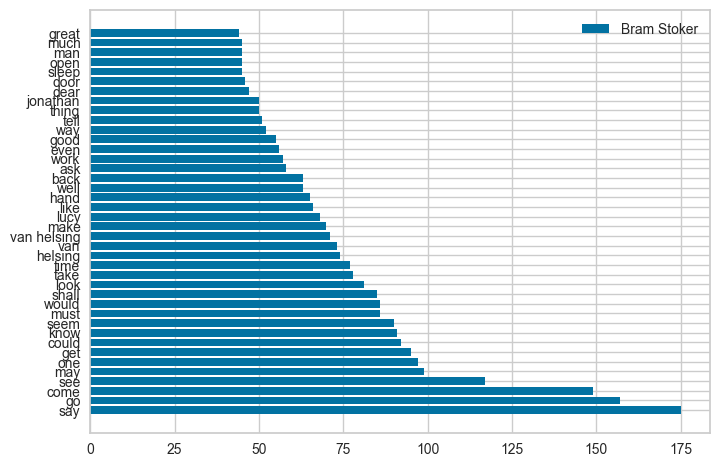

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]



for i in range(5):

    common_words = get_top_n_words(df_books[df_books['label']==i]['sentence'], 40)
    #for word, freq in common_words:
        #print(word, freq)

    df1 = pd.DataFrame(common_words, columns = ['word' , 'count'])
    #df1.groupby('word').sum()['count'].sort_values(ascending=False).plot(kind='bar', title='Top 40 words')
    #print(Author_dic.get(i))
    fig, ax = plt.subplots()
    ax.barh(df1['word'], df1['count'])
    ax.legend(df_books[df_books['label']==i]['author'])





In [ ]:
# split the data to intput  and Target
X = df_books['sentence']
Y = df_books['label']

# Set of BOW

In [ ]:

# transform the data to a BOW
# if you get error in CountVectorizer' object has no attribute 'get_feature_names' ues the line with get_feature_names_out
vect = CountVectorizer()
X_BOW = vect.fit_transform(X)
count_array = X_BOW.toarray()
#df_books_BOW = pd.DataFrame(count_array,columns = vect.get_feature_names())
df_books_BOW = pd.DataFrame(count_array,columns = vect.get_feature_names_out())
df_books_BOW

,aback,abandon,abandonment,abbey,abbot,abide,ability,able,ablewhite,ablewhites,...,zane,zaraïsk,zigzag,zoo,zoological,zossimov,zoöphagous,zumpt,æsthetics,ça
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\yellowbrick\text\tsne.py:401: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  self.ax.scatter(


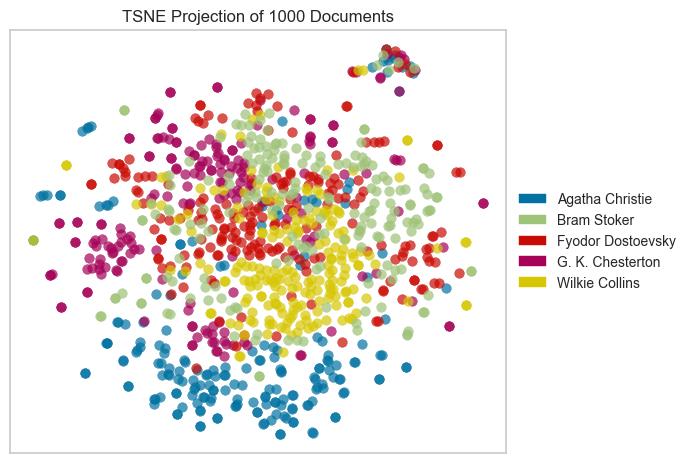

<Axes: title={'center': 'TSNE Projection of 1000 Documents'}>

In [ ]:

tsne = TSNEVisualizer()
tsne.fit(df_books_BOW,df_books['author'])
tsne.show()


# set of TF IDF

In [ ]:
# transform the data to a tf-idf representation
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(df_books["sentence"])
#print(tfidf_vectorizer_vectors.toarray())
#print(tfidf_vectorizer.get_feature_names())
# if you get error in CountVectorizer' object has no attribute 'get_feature_names' ues the line with get_feature_names_out
#df_books_tf_idf = pd.DataFrame(tfidf_vectorizer_vectors.toarray(),columns=tfidf_vectorizer.get_feature_names())
df_books_tf_idf = pd.DataFrame(tfidf_vectorizer_vectors.toarray(),columns=tfidf_vectorizer.get_feature_names_out())
df_books_tf_idf

,aback,abandon,abandonment,abbey,abbot,abide,ability,able,ablewhite,ablewhites,...,zane,zaraïsk,zigzag,zoo,zoological,zossimov,zoöphagous,zumpt,æsthetics,ça
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.124838,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.102486,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.106630,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\yellowbrick\text\tsne.py:401: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  self.ax.scatter(


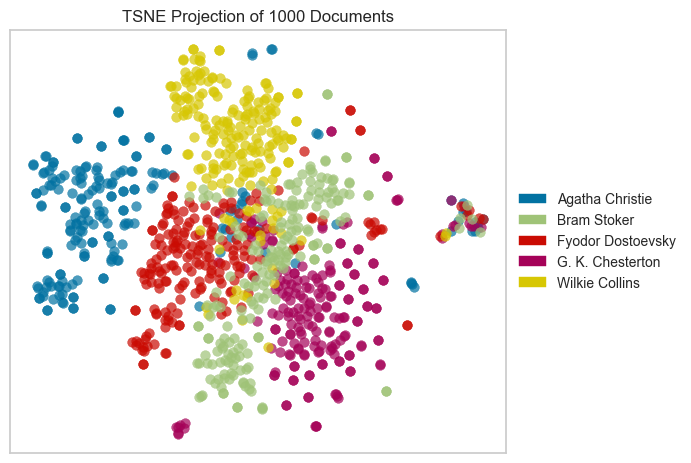

In [ ]:

tsne = TSNEVisualizer()
tsne.fit(df_books_tf_idf,df_books['author'])

tsne.show(legend=["Author 1","Author 2","Author 3","Author 4","Author 5"])
plt.show()

# set of Ngram

In [ ]:
#N_gram
count_vect = CountVectorizer(ngram_range=(1,3))
ngram_vectors=count_vect.fit_transform(df_books["sentence"])
# if you get error in CountVectorizer' object has no attribute 'get_feature_names' ues the line with get_feature_names_out
#df_books_ngram = pd.DataFrame(ngram_vectors.toarray(),columns=count_vect.get_feature_names())
df_books_ngram = pd.DataFrame(ngram_vectors.toarray(),columns=count_vect.get_feature_names_out())
df_books_ngram

,aback,aback bow,aback bow understand,aback case,aback case seem,aback make,aback make best,aback minute,aback minute know,aback seriously,...,zoöphagous,zoöphagous patient,zoöphagous patient report,zumpt,æsthetics,æsthetics schiller,æsthetics schiller idealist,ça,ça poor,ça poor man
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\yellowbrick\text\tsne.py:401: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  self.ax.scatter(


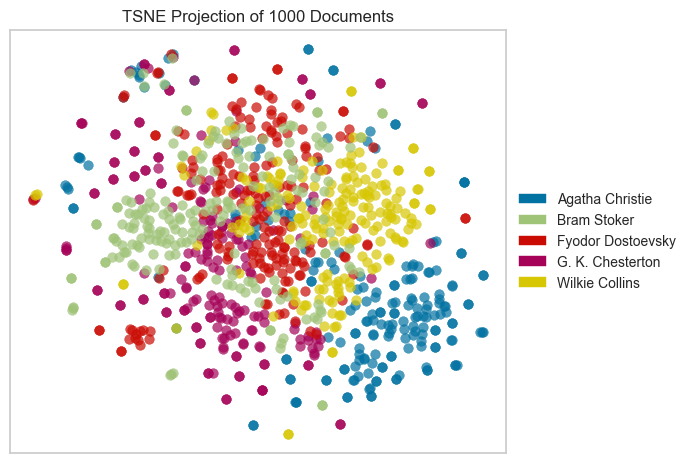

In [ ]:

tsne = TSNEVisualizer()
tsne.fit(df_books_ngram,df_books['author'])

tsne.show(legend=["Author 1","Author 2","Author 3","Author 4","Author 5"])
plt.show()

In [ ]:
##########################################################################################
##########################################################################################
##########################################################################################
##########################################################################################
##########################################################################################

#

# Apply Algthims

In [ ]:
def plot_confusion_matrix(cm,dataframe=df_books,title='Confusion matrix', cmap=plt.cm.CMRmap):
    plt.axis('off')
    plt.imshow(cm, interpolation='nearest', cmap='Purples')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(dataframe.label.unique()))
    print(tick_marks)
    plt.xticks(tick_marks, rotation=0)
    ax = plt.gca()
    ax.set_xticklabels((ax.get_xticks() +1).astype(str))
    plt.yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.show()

In [ ]:
# create a function to train and test the model with different performance metrics



def test_model(model, X_test, y_test):
    #print model name
    print("#######################################TEST#######################################################")
    print(model.__class__.__name__)
    y_pred_class = model.predict(X_test)

    print("-"*50)
    print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))
    print("-"*50)
    print('Confusion Matrix: \n ', confusion_matrix(y_test, y_pred_class))
    print("-"*50)
    print('Classification Report:\n ', metrics.classification_report(y_test, y_pred_class))
    print("complimatnt of Mean Squared Error : ",1-mean_squared_error(y_test,y_pred_class))
    print("#######################################TEST#######################################################")
    plot_confusion_matrix(confusion_matrix(y_test, y_pred_class))
    return (1-mean_squared_error(y_test,y_pred_class))




In [ ]:
def train_test_model(model,input_data,traget,number_of_kfold=10):
    X_train, X_test, y_train, y_test = train_test_split(input_data, traget, test_size=0.2, random_state=1)
    kf = KFold(n_splits=number_of_kfold, shuffle=True, random_state=42)
    fold_accuracies = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(input_data)):
        print(f"Fold {fold+1}")
        X_train, y_train = input_data[train_idx], traget[train_idx]
        X_val, y_val = input_data[val_idx], traget[val_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        print(f"Accuracy: {accuracy}")
        print("Claassification report:\n",classification_report(y_val, y_pred))
        fold_accuracies.append(accuracy)
    #test_set
    reslust=test_model(model, X_test, y_test)
    fold_accuracies.append(reslust)
    data = [random.randint(0, 20) for i in range(0, 10)]  #create a list of 10 random numbers

    plt.plot(fold_accuracies, color='magenta', marker='o',mfc='pink' ) #plot the data
    plt.xticks(range(0,len(fold_accuracies)+1, 1)) #set the tick frequency on x-axis

    plt.ylabel('Accuracy') #set the label for y axis
    plt.xlabel('index') #set the label for x-axis
    plt.title("Plotting a list") #set the title of the graph
    plt.show() #display the graph
    print(fold_accuracies)


    return  fold_accuracies


# RandomForestClassifier

BOW

Fold 1
Accuracy: 0.9
Claassification report:
               precision    recall  f1-score   support

           0       0.86      0.95      0.90        19
           1       0.96      0.92      0.94        24
           2       0.88      0.94      0.91        16
           3       0.90      0.95      0.92        19
           4       0.89      0.77      0.83        22

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100

Fold 2
Accuracy: 0.93
Claassification report:
               precision    recall  f1-score   support

           0       1.00      0.82      0.90        22
           1       0.95      1.00      0.98        21
           2       0.85      0.85      0.85        20
           3       1.00      1.00      1.00        18
           4       0.86      1.00      0.93        19

    accuracy                           0.93       100
   macro avg       0.93      0.93     

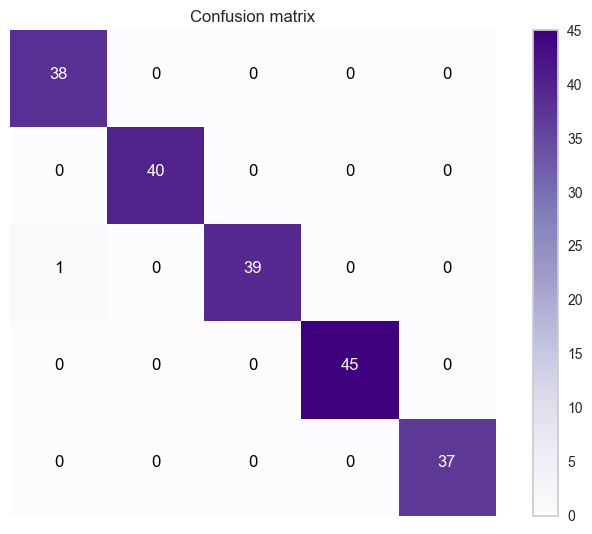

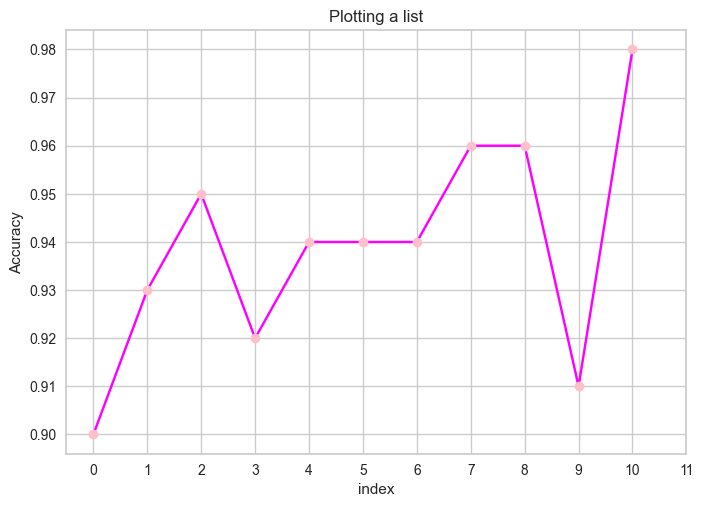

[0.9, 0.93, 0.95, 0.92, 0.94, 0.94, 0.94, 0.96, 0.96, 0.91, 0.98]


In [ ]:

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
Reslut_from_Random_Forest_Classifier_BOW=train_test_model(rfc,X_BOW,Y,number_of_kfold=10)


tf-idf

Fold 1
Accuracy: 0.9
Claassification report:
               precision    recall  f1-score   support

           0       0.86      0.95      0.90        19
           1       0.92      0.96      0.94        24
           2       0.88      0.94      0.91        16
           3       0.90      0.95      0.92        19
           4       0.94      0.73      0.82        22

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100

Fold 2
Accuracy: 0.92
Claassification report:
               precision    recall  f1-score   support

           0       1.00      0.82      0.90        22
           1       0.95      1.00      0.98        21
           2       0.79      0.95      0.86        20
           3       0.94      0.94      0.94        18
           4       0.94      0.89      0.92        19

    accuracy                           0.92       100
   macro avg       0.93      0.92     

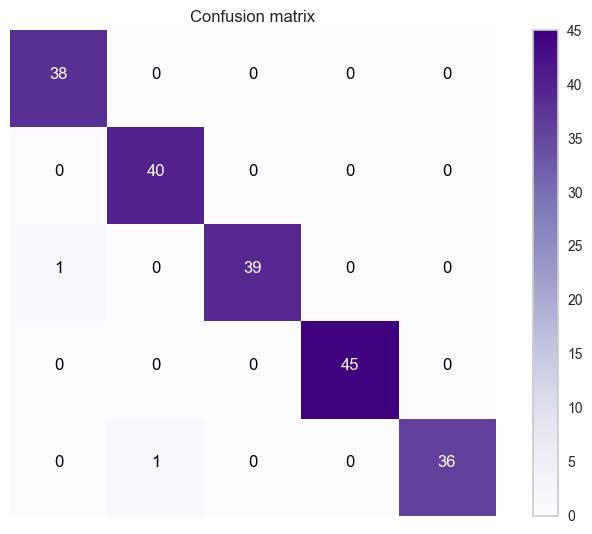

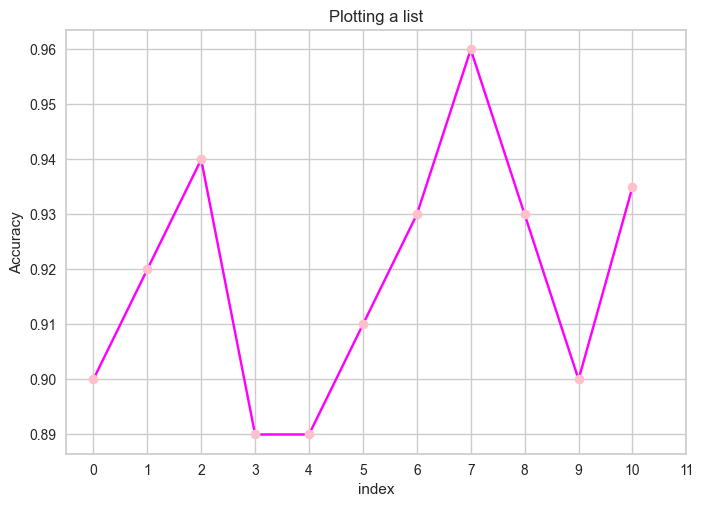

[0.9, 0.92, 0.94, 0.89, 0.89, 0.91, 0.93, 0.96, 0.93, 0.9, 0.935]


In [ ]:
Reslut_from_Random_Forest_Classifier_TF_IDF=train_test_model(rfc,tfidf_vectorizer_vectors,Y,number_of_kfold=10)

Ngram

Fold 1
Accuracy: 0.91
Claassification report:
               precision    recall  f1-score   support

           0       0.86      0.95      0.90        19
           1       0.96      0.96      0.96        24
           2       0.88      0.94      0.91        16
           3       0.90      0.95      0.92        19
           4       0.94      0.77      0.85        22

    accuracy                           0.91       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100

Fold 2
Accuracy: 0.93
Claassification report:
               precision    recall  f1-score   support

           0       1.00      0.82      0.90        22
           1       0.91      1.00      0.95        21
           2       0.86      0.95      0.90        20
           3       0.95      1.00      0.97        18
           4       0.94      0.89      0.92        19

    accuracy                           0.93       100
   macro avg       0.93      0.93    

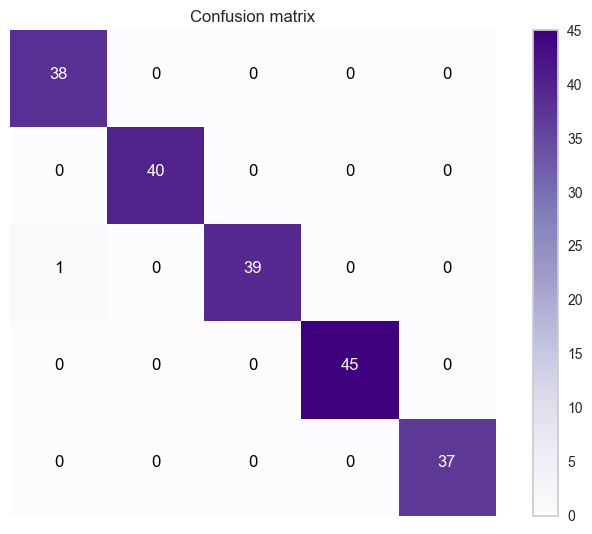

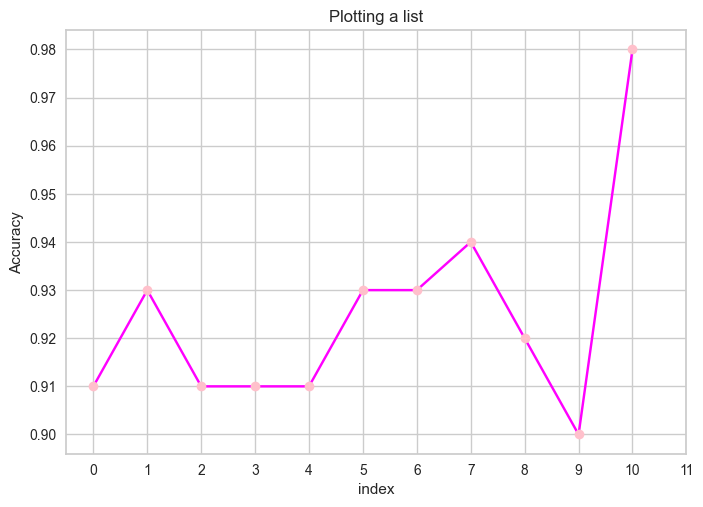

[0.91, 0.93, 0.91, 0.91, 0.91, 0.93, 0.93, 0.94, 0.92, 0.9, 0.98]


In [ ]:
Reslut_from_Random_Forest_Classifier_Ngram=train_test_model(rfc,ngram_vectors,Y,number_of_kfold=10)

#######################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

# Naive Bayes

BOW

Fold 1
Accuracy: 0.94
Claassification report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.90        19
           1       0.96      0.96      0.96        24
           2       0.94      0.94      0.94        16
           3       1.00      0.95      0.97        19
           4       1.00      0.86      0.93        22

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.95      0.94      0.94       100

Fold 2
Accuracy: 0.96
Claassification report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93        22
           1       0.95      0.90      0.93        21
           2       0.95      1.00      0.98        20
           3       1.00      1.00      1.00        18
           4       0.95      1.00      0.97        19

    accuracy                           0.96       100
   macro avg       0.96      0.96    

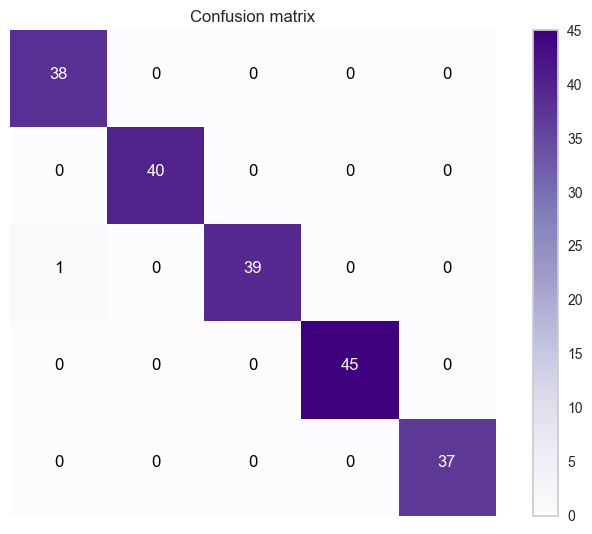

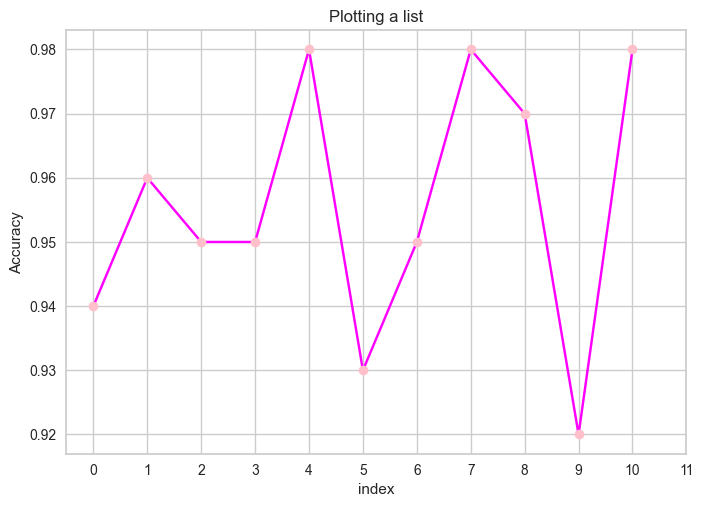

[0.94, 0.96, 0.95, 0.95, 0.98, 0.93, 0.95, 0.98, 0.97, 0.92, 0.98]


In [ ]:
# train and test the model with Naive Bayes

nb = MultinomialNB()
Reslut_from_Naive_Bayes_BOW=train_test_model(nb,X_BOW,Y,number_of_kfold=10)

tf-idf

Fold 1
Accuracy: 0.94
Claassification report:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88        19
           1       0.96      0.96      0.96        24
           2       1.00      0.94      0.97        16
           3       1.00      0.95      0.97        19
           4       1.00      0.86      0.93        22

    accuracy                           0.94       100
   macro avg       0.95      0.94      0.94       100
weighted avg       0.95      0.94      0.94       100

Fold 2
Accuracy: 0.96
Claassification report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93        22
           1       0.95      0.90      0.93        21
           2       0.95      1.00      0.98        20
           3       1.00      1.00      1.00        18
           4       0.95      1.00      0.97        19

    accuracy                           0.96       100
   macro avg       0.96      0.96    

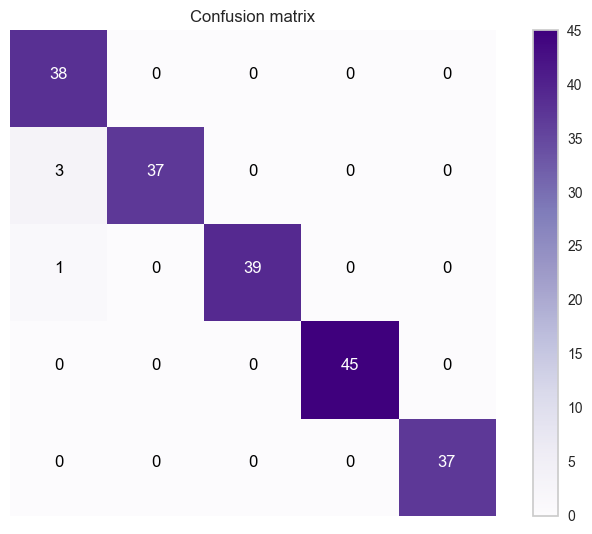

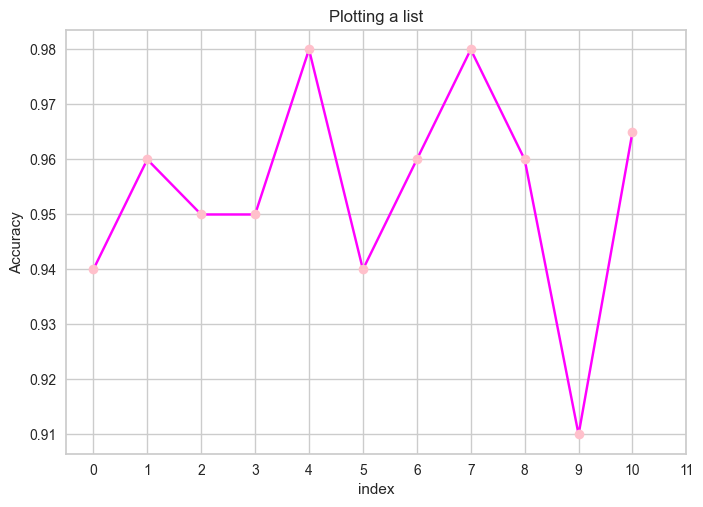

[0.94, 0.96, 0.95, 0.95, 0.98, 0.94, 0.96, 0.98, 0.96, 0.91, 0.965]


In [ ]:
Reslut_from_Naive_Bayes_tfidf=train_test_model(nb,tfidf_vectorizer_vectors,Y,number_of_kfold=10)

Ngram

Fold 1
Accuracy: 0.93
Claassification report:
               precision    recall  f1-score   support

           0       0.82      0.95      0.88        19
           1       0.96      0.96      0.96        24
           2       0.94      0.94      0.94        16
           3       0.95      0.95      0.95        19
           4       1.00      0.86      0.93        22

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.94      0.93      0.93       100

Fold 2
Accuracy: 0.97
Claassification report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95        22
           1       1.00      0.95      0.98        21
           2       0.91      1.00      0.95        20
           3       1.00      1.00      1.00        18
           4       0.95      1.00      0.97        19

    accuracy                           0.97       100
   macro avg       0.97      0.97    

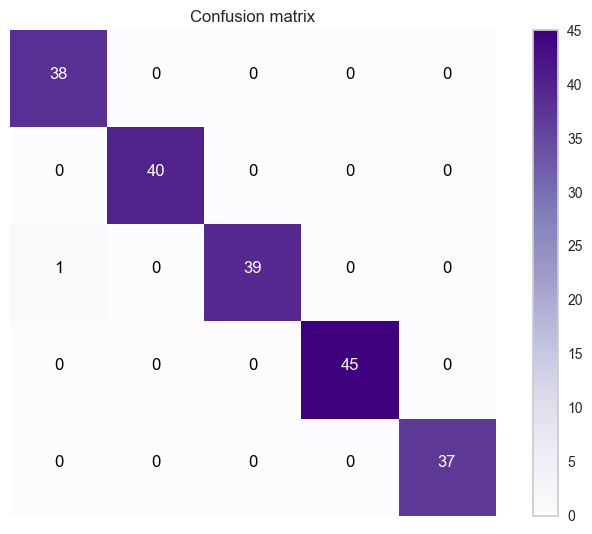

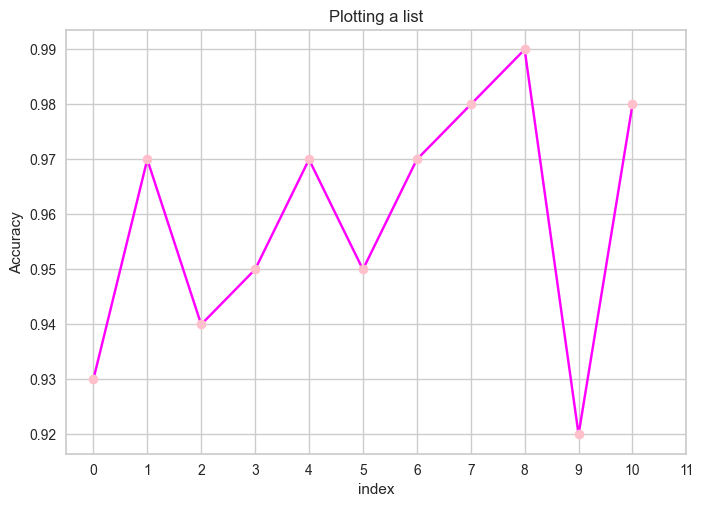

[0.93, 0.97, 0.94, 0.95, 0.97, 0.95, 0.97, 0.98, 0.99, 0.92, 0.98]


In [ ]:
Reslut_from_Naive_Bayes_ngram=train_test_model(nb,ngram_vectors,Y,number_of_kfold=10)

#######################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

# XGBoots

BOW

Fold 1
Accuracy: 0.87
Claassification report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85        19
           1       0.91      0.83      0.87        24
           2       0.78      0.88      0.82        16
           3       0.95      0.95      0.95        19
           4       0.90      0.82      0.86        22

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100

Fold 2
Accuracy: 0.84
Claassification report:
               precision    recall  f1-score   support

           0       0.94      0.68      0.79        22
           1       0.95      0.86      0.90        21
           2       0.81      0.85      0.83        20
           3       0.84      0.89      0.86        18
           4       0.72      0.95      0.82        19

    accuracy                           0.84       100
   macro avg       0.85      0.85    

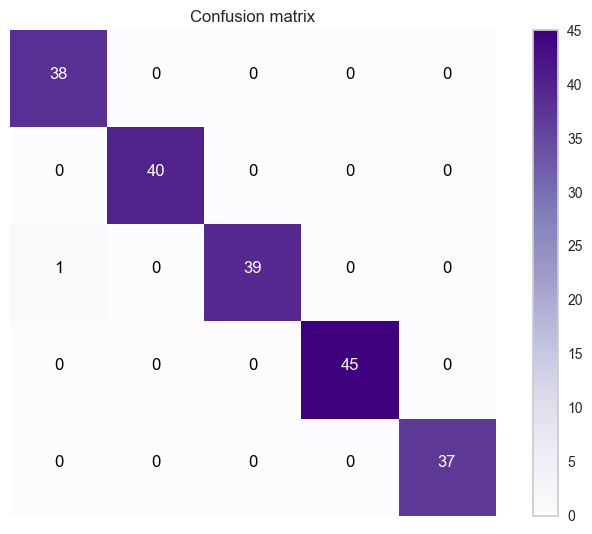

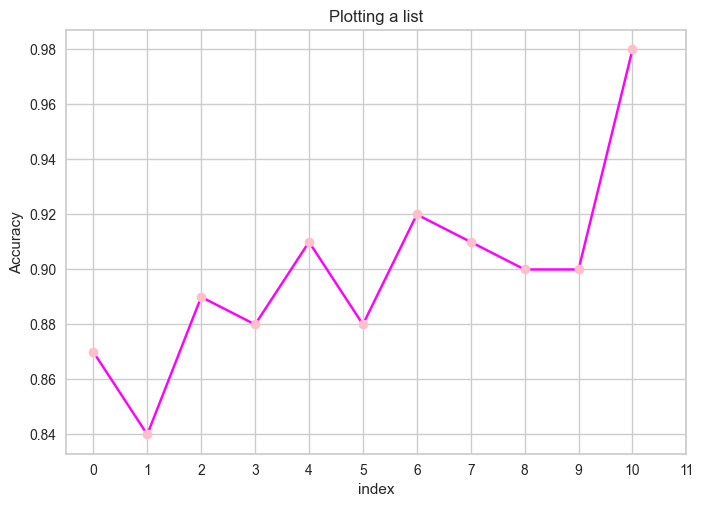

[0.87, 0.84, 0.89, 0.88, 0.91, 0.88, 0.92, 0.91, 0.9, 0.9, 0.98]


In [ ]:
# train and test the model with XGBoost
from xgboost import XGBClassifier
xgb = XGBClassifier()
Reslut_from_xgb_BOW=train_test_model(xgb,X_BOW,Y,number_of_kfold=10)

tf-idf

Fold 1
Accuracy: 0.85
Claassification report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85        19
           1       0.91      0.83      0.87        24
           2       0.78      0.88      0.82        16
           3       0.89      0.89      0.89        19
           4       0.85      0.77      0.81        22

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

Fold 2
Accuracy: 0.84
Claassification report:
               precision    recall  f1-score   support

           0       0.94      0.68      0.79        22
           1       0.95      0.86      0.90        21
           2       0.77      0.85      0.81        20
           3       0.94      0.94      0.94        18
           4       0.68      0.89      0.77        19

    accuracy                           0.84       100
   macro avg       0.86      0.85    

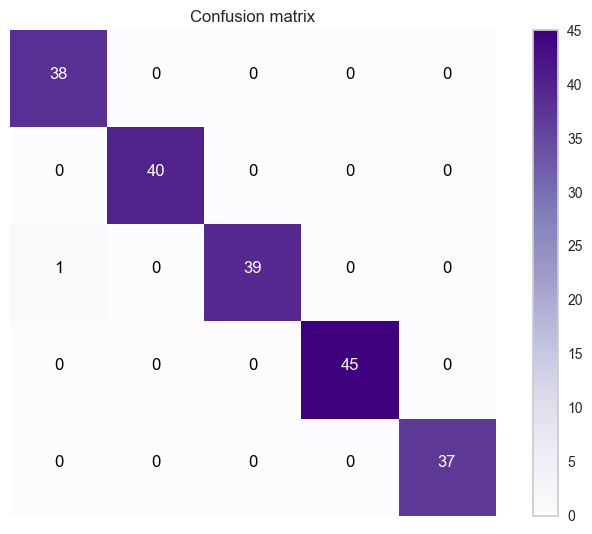

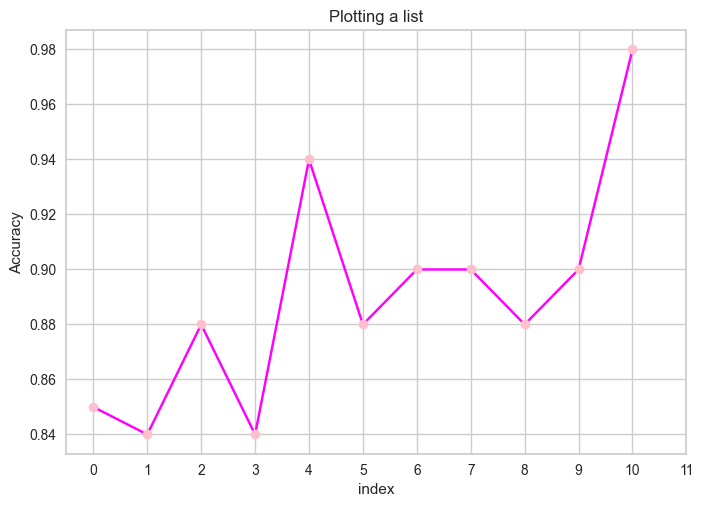

[0.85, 0.84, 0.88, 0.84, 0.94, 0.88, 0.9, 0.9, 0.88, 0.9, 0.98]


In [ ]:
Reslut_from_xgb_tf_idf=train_test_model(xgb,tfidf_vectorizer_vectors,Y,number_of_kfold=10)

Ngram

Fold 1
Accuracy: 0.86
Claassification report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85        19
           1       0.91      0.83      0.87        24
           2       0.82      0.88      0.85        16
           3       0.86      0.95      0.90        19
           4       0.89      0.77      0.83        22

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100

Fold 2
Accuracy: 0.83
Claassification report:
               precision    recall  f1-score   support

           0       0.94      0.68      0.79        22
           1       0.90      0.86      0.88        21
           2       0.74      0.85      0.79        20
           3       0.89      0.89      0.89        18
           4       0.74      0.89      0.81        19

    accuracy                           0.83       100
   macro avg       0.84      0.83    

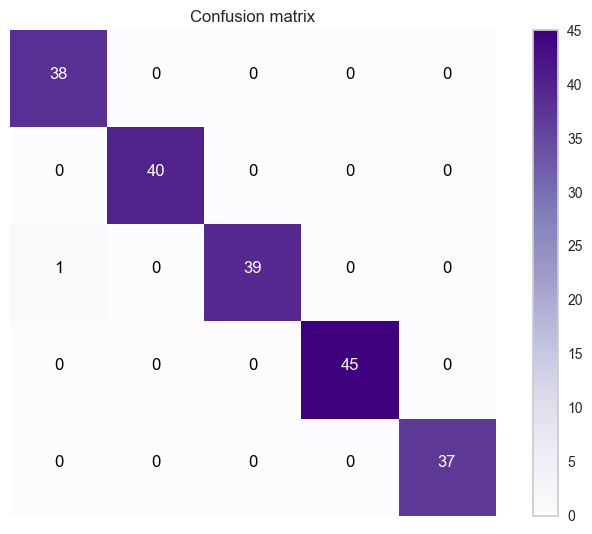

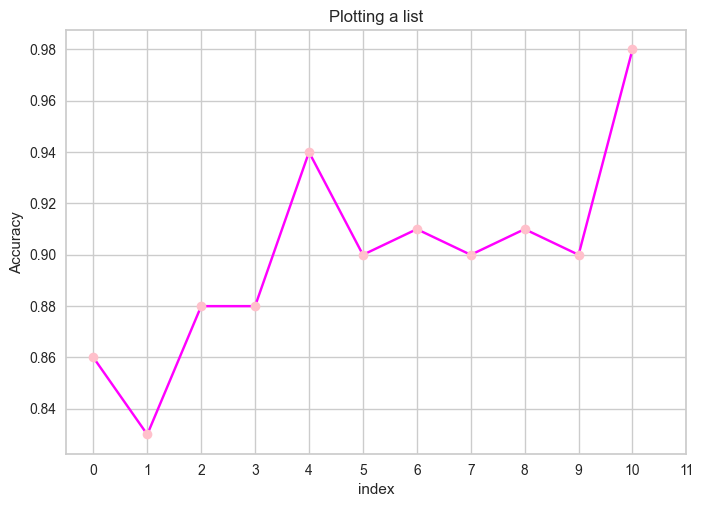

[0.86, 0.83, 0.88, 0.88, 0.94, 0.9, 0.91, 0.9, 0.91, 0.9, 0.98]


In [ ]:
Reslut_from_xgb_ngram=train_test_model(xgb,ngram_vectors,Y,number_of_kfold=10)

# KNN

BOW

Fold 1
Accuracy: 0.71
Claassification report:
               precision    recall  f1-score   support

           0       0.55      0.95      0.69        19
           1       0.79      0.79      0.79        24
           2       0.67      0.50      0.57        16
           3       0.85      0.58      0.69        19
           4       0.83      0.68      0.75        22

    accuracy                           0.71       100
   macro avg       0.74      0.70      0.70       100
weighted avg       0.74      0.71      0.71       100

Fold 2
Accuracy: 0.74
Claassification report:
               precision    recall  f1-score   support

           0       0.67      0.82      0.73        22
           1       0.76      0.90      0.83        21
           2       0.71      0.50      0.59        20
           3       0.76      0.72      0.74        18
           4       0.82      0.74      0.78        19

    accuracy                           0.74       100
   macro avg       0.75      0.74    

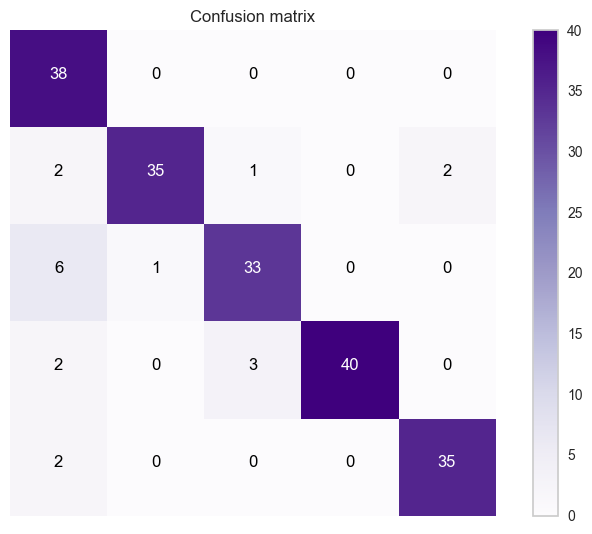

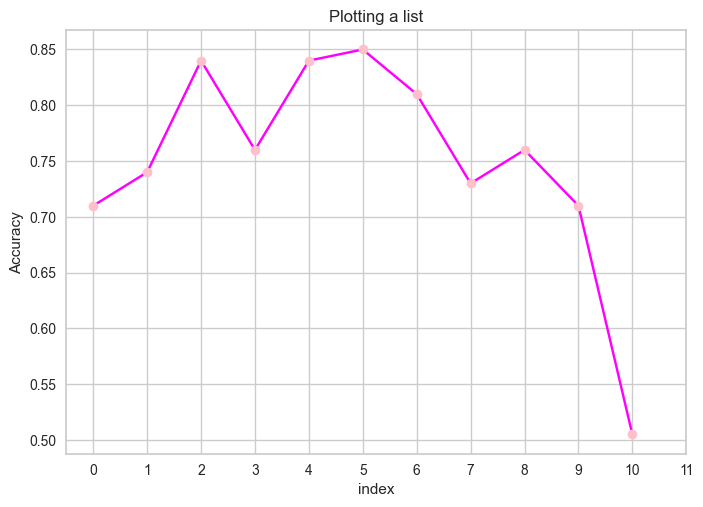

[0.71, 0.74, 0.84, 0.76, 0.84, 0.85, 0.81, 0.73, 0.76, 0.71, 0.505]


In [ ]:


KNN = KNeighborsClassifier(n_neighbors = 3, algorithm= 'brute', p= 1)

Reslut_from_KNN_BOW = train_test_model(KNN,X_BOW,Y,number_of_kfold= 10)

tf-idf

Fold 1
Accuracy: 0.34
Claassification report:
               precision    recall  f1-score   support

           0       0.47      0.47      0.47        19
           1       0.29      0.96      0.45        24
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00        19
           4       1.00      0.09      0.17        22

    accuracy                           0.34       100
   macro avg       0.35      0.30      0.22       100
weighted avg       0.38      0.34      0.23       100

Fold 2
Accuracy: 0.21
Claassification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.21      1.00      0.35        21
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        18
           4       0.00      0.00      0.00        19

    accuracy                           0.21       100
   macro avg       0.04      0.20    

C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nasse\anaconda3\envs\M

--------------------------------------------------
Accuracy:  0.3
--------------------------------------------------
Confusion Matrix: 
  [[13 25  0  0  0]
 [ 0 40  0  0  0]
 [ 2 38  0  0  0]
 [ 0 44  0  1  0]
 [ 0 31  0  0  6]]
--------------------------------------------------
Classification Report:
                precision    recall  f1-score   support

           0       0.87      0.34      0.49        38
           1       0.22      1.00      0.37        40
           2       0.00      0.00      0.00        40
           3       1.00      0.02      0.04        45
           4       1.00      0.16      0.28        37

    accuracy                           0.30       200
   macro avg       0.62      0.31      0.24       200
weighted avg       0.62      0.30      0.23       200

complimatnt of Mean Squared Error :  -1.63
#######################################TEST#######################################################
[0 1 2 3 4]


C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


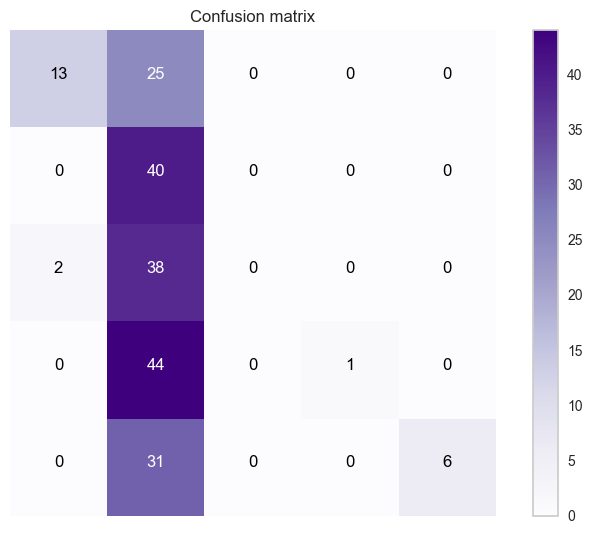

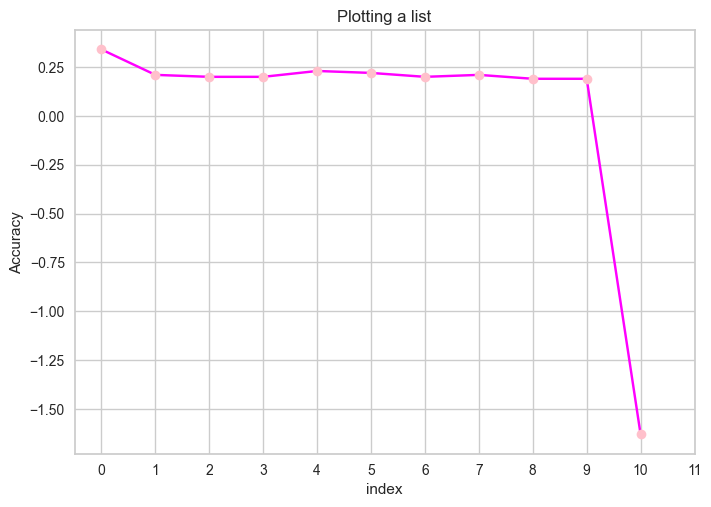

[0.34, 0.21, 0.2, 0.2, 0.23, 0.22, 0.2, 0.21, 0.19, 0.19, -1.63]


In [ ]:
Reslut_from_KNN_Tf_idf= train_test_model(KNN,tfidf_vectorizer_vectors,Y,number_of_kfold= 10)

Ngram

Fold 1
Accuracy: 0.76
Claassification report:
               precision    recall  f1-score   support

           0       0.60      0.95      0.73        19
           1       0.84      0.88      0.86        24
           2       0.69      0.69      0.69        16
           3       0.91      0.53      0.67        19
           4       0.89      0.73      0.80        22

    accuracy                           0.76       100
   macro avg       0.79      0.75      0.75       100
weighted avg       0.79      0.76      0.76       100

Fold 2
Accuracy: 0.73
Claassification report:
               precision    recall  f1-score   support

           0       0.66      0.86      0.75        22
           1       0.74      0.81      0.77        21
           2       0.80      0.60      0.69        20
           3       0.83      0.56      0.67        18
           4       0.71      0.79      0.75        19

    accuracy                           0.73       100
   macro avg       0.75      0.72    

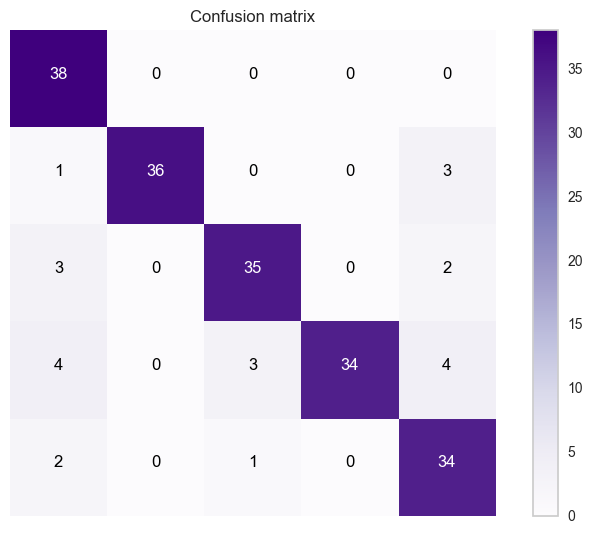

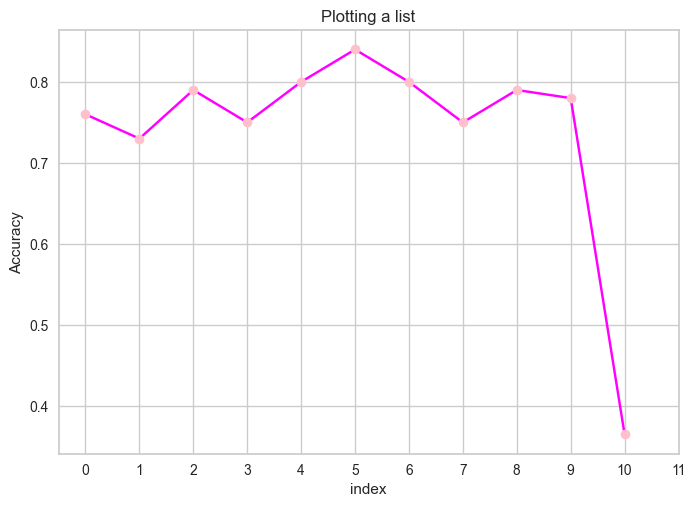

[0.76, 0.73, 0.79, 0.75, 0.8, 0.84, 0.8, 0.75, 0.79, 0.78, 0.365]


In [ ]:
Reslut_from_KNN_Ngram = train_test_model(KNN,ngram_vectors,Y,number_of_kfold= 10)

SVM

Fold 1
Accuracy: 0.92
Claassification report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85        19
           1       0.96      0.96      0.96        24
           2       0.88      0.94      0.91        16
           3       1.00      0.95      0.97        19
           4       0.95      0.86      0.90        22

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100

Fold 2
Accuracy: 0.92
Claassification report:
               precision    recall  f1-score   support

           0       0.95      0.82      0.88        22
           1       0.90      0.86      0.88        21
           2       0.87      1.00      0.93        20
           3       1.00      0.94      0.97        18
           4       0.90      1.00      0.95        19

    accuracy                           0.92       100
   macro avg       0.92      0.92    

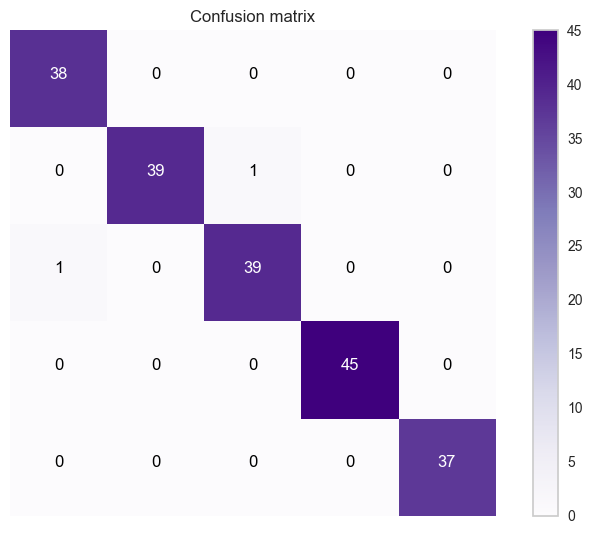

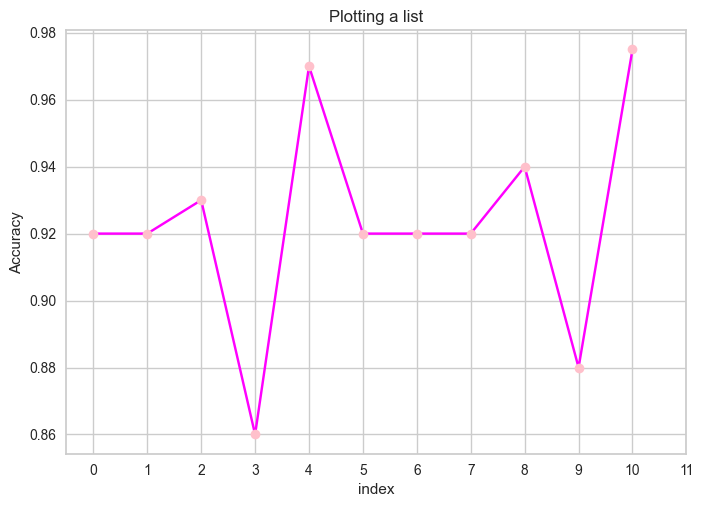

[0.92, 0.92, 0.93, 0.86, 0.97, 0.92, 0.92, 0.92, 0.94, 0.88, 0.975]


In [ ]:

svm = SVC(kernel='rbf')
Result_from_svm_BOW= train_test_model(svm, X_BOW,Y,number_of_kfold = 10)

tf-idf

Fold 1
Accuracy: 0.93
Claassification report:
               precision    recall  f1-score   support

           0       0.82      0.95      0.88        19
           1       0.96      0.96      0.96        24
           2       0.88      0.94      0.91        16
           3       1.00      0.95      0.97        19
           4       1.00      0.86      0.93        22

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.94      0.93      0.93       100

Fold 2
Accuracy: 0.92
Claassification report:
               precision    recall  f1-score   support

           0       0.95      0.82      0.88        22
           1       0.90      0.86      0.88        21
           2       0.91      1.00      0.95        20
           3       1.00      0.94      0.97        18
           4       0.86      1.00      0.93        19

    accuracy                           0.92       100
   macro avg       0.92      0.92    

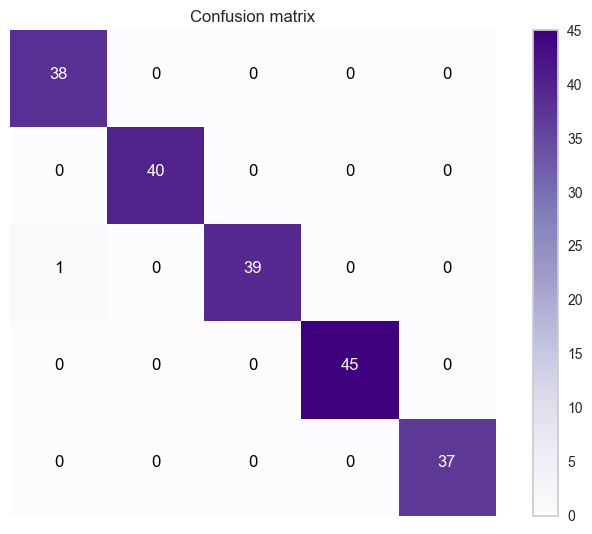

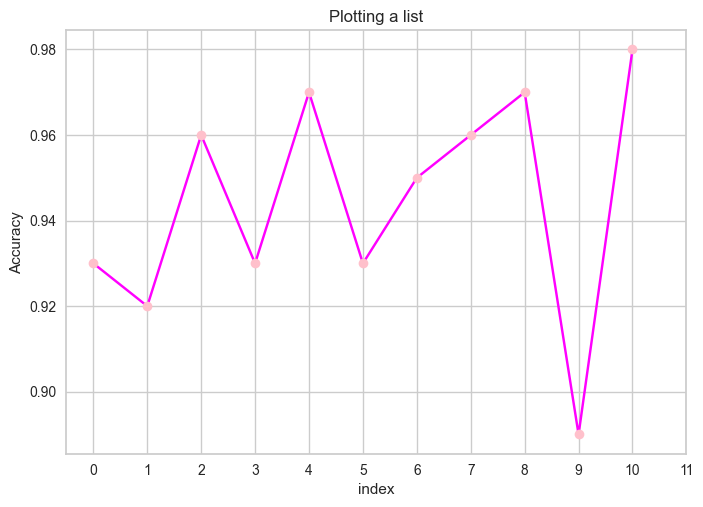

[0.93, 0.92, 0.96, 0.93, 0.97, 0.93, 0.95, 0.96, 0.97, 0.89, 0.98]


In [ ]:
Result_from_svm_tf_idf= train_test_model(svm,tfidf_vectorizer_vectors,Y,number_of_kfold = 10)

Ngram

Fold 1
Accuracy: 0.91
Claassification report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85        19
           1       0.96      0.92      0.94        24
           2       0.88      0.94      0.91        16
           3       0.95      0.95      0.95        19
           4       0.95      0.86      0.90        22

    accuracy                           0.91       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100

Fold 2
Accuracy: 0.89
Claassification report:
               precision    recall  f1-score   support

           0       0.89      0.73      0.80        22
           1       0.94      0.81      0.87        21
           2       0.77      1.00      0.87        20
           3       0.94      0.94      0.94        18
           4       0.95      1.00      0.97        19

    accuracy                           0.89       100
   macro avg       0.90      0.90    

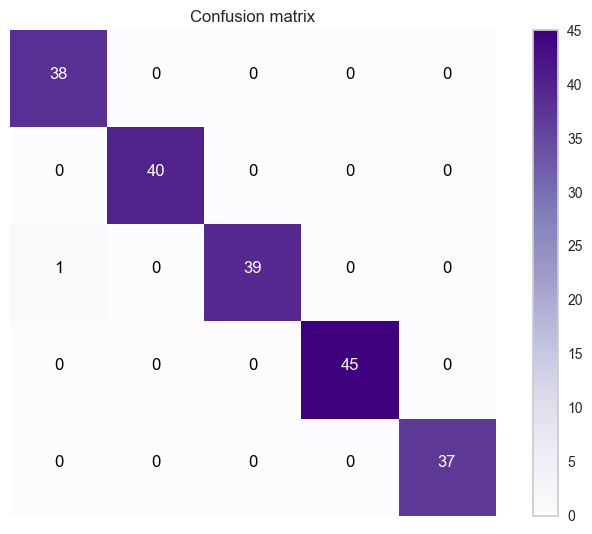

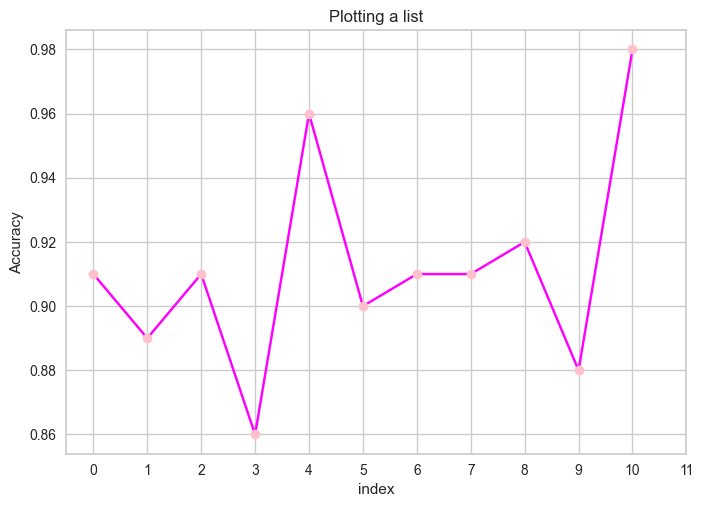

[0.91, 0.89, 0.91, 0.86, 0.96, 0.9, 0.91, 0.91, 0.92, 0.88, 0.98]


In [ ]:
Result_from_svm_ngram= train_test_model(svm,ngram_vectors,Y,number_of_kfold = 10)

# SGDClassifier

BOW

Fold 1
Accuracy: 0.93
Claassification report:
               precision    recall  f1-score   support

           0       0.82      0.95      0.88        19
           1       0.96      0.96      0.96        24
           2       0.88      0.94      0.91        16
           3       1.00      0.95      0.97        19
           4       1.00      0.86      0.93        22

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.94      0.93      0.93       100

Fold 2
Accuracy: 0.92
Claassification report:
               precision    recall  f1-score   support

           0       0.95      0.82      0.88        22
           1       0.90      0.90      0.90        21
           2       0.90      0.95      0.93        20
           3       1.00      0.94      0.97        18
           4       0.86      1.00      0.93        19

    accuracy                           0.92       100
   macro avg       0.92      0.92    

C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy: 0.91
Claassification report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87        15
           1       0.94      0.80      0.86        20
           2       0.84      0.95      0.89        22
           3       1.00      0.95      0.98        22
           4       0.91      0.95      0.93        21

    accuracy                           0.91       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100

Fold 5
Accuracy: 0.96
Claassification report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        21
           1       0.88      1.00      0.94        22
           2       1.00      0.95      0.98        22
           3       0.93      1.00      0.97        14
           4       1.00      0.95      0.98        21

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96 

C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Claassification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.90      0.95        20
           2       0.95      0.95      0.95        22
           3       0.96      0.89      0.93        28
           4       0.79      1.00      0.88        15

    accuracy                           0.94       100
   macro avg       0.94      0.95      0.94       100
weighted avg       0.95      0.94      0.94       100

Fold 9
Accuracy: 0.96
Claassification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.93      0.88      0.90        16
           2       0.95      0.95      0.95        21
           3       1.00      1.00      1.00        18
           4       0.93      0.96      0.94        26

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weigh

C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


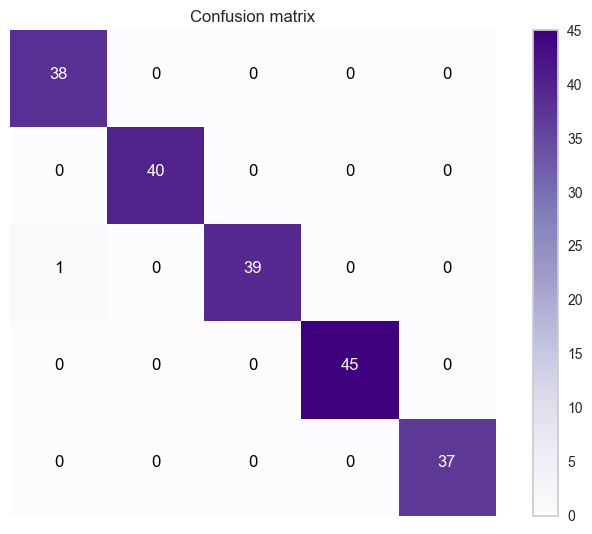

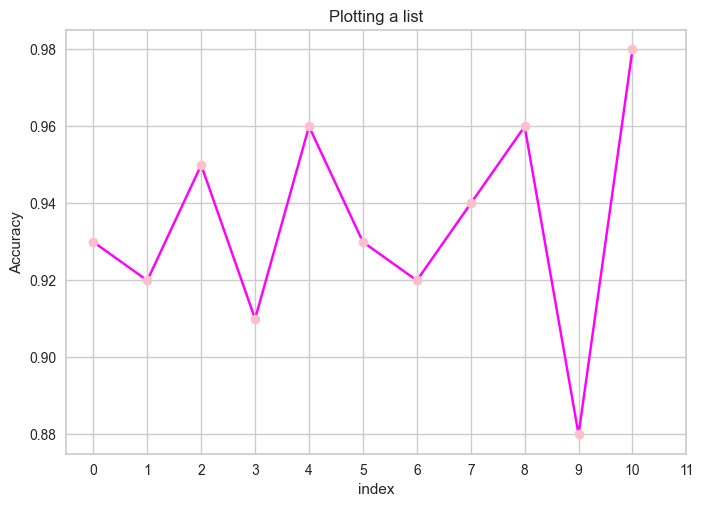

[0.93, 0.92, 0.95, 0.91, 0.96, 0.93, 0.92, 0.94, 0.96, 0.88, 0.98]


In [ ]:



# Initialize the SGD classifier
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.0001, learning_rate='constant', eta0=0.01, max_iter=1000, random_state=42)

# Train the classifier using SGD
Result_from_sgd_BOW= train_test_model(sgd,X_BOW,Y,number_of_kfold = 10)

tf-idf

Fold 1
Accuracy: 0.94
Claassification report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.90        19
           1       0.96      0.96      0.96        24
           2       1.00      0.94      0.97        16
           3       0.95      0.95      0.95        19
           4       1.00      0.86      0.93        22

    accuracy                           0.94       100
   macro avg       0.95      0.94      0.94       100
weighted avg       0.95      0.94      0.94       100

Fold 2


C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy: 0.95
Claassification report:
               precision    recall  f1-score   support

           0       0.95      0.82      0.88        22
           1       0.91      0.95      0.93        21
           2       0.91      1.00      0.95        20
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00        19

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Fold 3
Accuracy: 0.97
Claassification report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.90      1.00      0.95        18
           2       1.00      0.96      0.98        23
           3       1.00      1.00      1.00        19
           4       1.00      0.95      0.97        19

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97 

C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy: 0.93
Claassification report:
               precision    recall  f1-score   support

           0       0.82      0.93      0.87        15
           1       1.00      0.85      0.92        20
           2       0.95      0.95      0.95        22
           3       0.95      0.95      0.95        22
           4       0.91      0.95      0.93        21

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100

Fold 5
Accuracy: 0.97
Claassification report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.92      1.00      0.96        22
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        14
           4       1.00      0.95      0.98        21

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97 

C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy: 0.93
Claassification report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        28
           1       0.94      0.89      0.92        19
           2       1.00      0.86      0.92        14
           3       1.00      0.91      0.95        22
           4       0.77      1.00      0.87        17

    accuracy                           0.93       100
   macro avg       0.94      0.93      0.93       100
weighted avg       0.94      0.93      0.93       100

Fold 7
Accuracy: 0.96
Claassification report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92        14
           1       0.91      1.00      0.95        20
           2       0.95      1.00      0.97        19
           3       0.95      0.95      0.95        21
           4       1.00      0.96      0.98        26

    accuracy                           0.96       100
   macro avg       0.96      0.95      0.96 

C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy: 0.98
Claassification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        22
           3       1.00      0.93      0.96        28
           4       0.88      1.00      0.94        15

    accuracy                           0.98       100
   macro avg       0.98      0.99      0.98       100
weighted avg       0.98      0.98      0.98       100

Fold 9
Accuracy: 0.97
Claassification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.93      0.88      0.90        16
           2       1.00      1.00      1.00        21
           3       1.00      1.00      1.00        18
           4       0.93      0.96      0.94        26

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97 

C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy: 0.91
Claassification report:
               precision    recall  f1-score   support

           0       0.89      0.96      0.93        26
           1       0.95      0.90      0.92        20
           2       0.94      0.81      0.87        21
           3       0.86      0.95      0.90        19
           4       0.93      0.93      0.93        14

    accuracy                           0.91       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100

#######################################TEST#######################################################
SGDClassifier
--------------------------------------------------
Accuracy:  0.995
--------------------------------------------------
Confusion Matrix: 
  [[38  0  0  0  0]
 [ 0 40  0  0  0]
 [ 1  0 39  0  0]
 [ 0  0  0 45  0]
 [ 0  0  0  0 37]]
--------------------------------------------------
Classification Report:
                precision    recall  f1-score   suppo

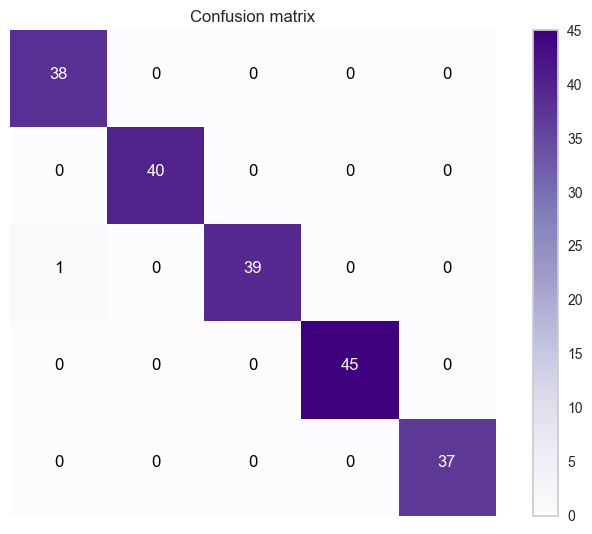

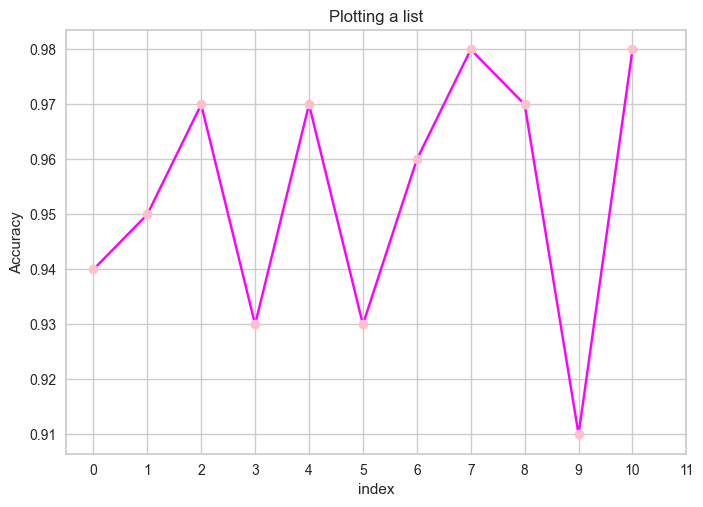

[0.94, 0.95, 0.97, 0.93, 0.97, 0.93, 0.96, 0.98, 0.97, 0.91, 0.98]


In [ ]:
Result_from_sgd_tf_idf= train_test_model(sgd,tfidf_vectorizer_vectors,Y,number_of_kfold = 10)

Ngram

Fold 1


C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy: 0.93
Claassification report:
               precision    recall  f1-score   support

           0       0.86      0.95      0.90        19
           1       0.96      0.96      0.96        24
           2       0.94      0.94      0.94        16
           3       0.95      0.95      0.95        19
           4       0.95      0.86      0.90        22

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100

Fold 2


C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy: 0.93
Claassification report:
               precision    recall  f1-score   support

           0       0.95      0.86      0.90        22
           1       0.95      0.95      0.95        21
           2       0.90      0.90      0.90        20
           3       0.94      0.94      0.94        18
           4       0.90      1.00      0.95        19

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100

Fold 3
Accuracy: 0.96
Claassification report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.86      1.00      0.92        18
           2       1.00      0.96      0.98        23
           3       1.00      0.95      0.97        19
           4       1.00      0.95      0.97        19

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96 

C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy: 0.9
Claassification report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87        15
           1       0.94      0.85      0.89        20
           2       0.87      0.91      0.89        22
           3       0.95      0.95      0.95        22
           4       0.86      0.90      0.88        21

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100

Fold 5
Accuracy: 0.97
Claassification report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        21
           1       0.92      1.00      0.96        22
           2       1.00      1.00      1.00        22
           3       0.93      1.00      0.97        14
           4       1.00      0.95      0.98        21

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97  

C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy: 0.93
Claassification report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        28
           1       1.00      0.89      0.94        19
           2       1.00      0.86      0.92        14
           3       1.00      0.91      0.95        22
           4       0.74      1.00      0.85        17

    accuracy                           0.93       100
   macro avg       0.94      0.93      0.93       100
weighted avg       0.95      0.93      0.93       100

Fold 7
Accuracy: 0.94
Claassification report:
               precision    recall  f1-score   support

           0       0.92      0.79      0.85        14
           1       0.95      1.00      0.98        20
           2       0.90      1.00      0.95        19
           3       0.95      0.90      0.93        21
           4       0.96      0.96      0.96        26

    accuracy                           0.94       100
   macro avg       0.94      0.93      0.93 

C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy: 0.93
Claassification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.90      0.95        20
           2       1.00      0.91      0.95        22
           3       0.96      0.89      0.93        28
           4       0.71      1.00      0.83        15

    accuracy                           0.93       100
   macro avg       0.94      0.94      0.93       100
weighted avg       0.95      0.93      0.93       100

Fold 9
Accuracy: 0.97
Claassification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.93      0.88      0.90        16
           2       1.00      1.00      1.00        21
           3       0.95      1.00      0.97        18
           4       0.96      0.96      0.96        26

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97 

C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nasse\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[0 1 2 3 4]


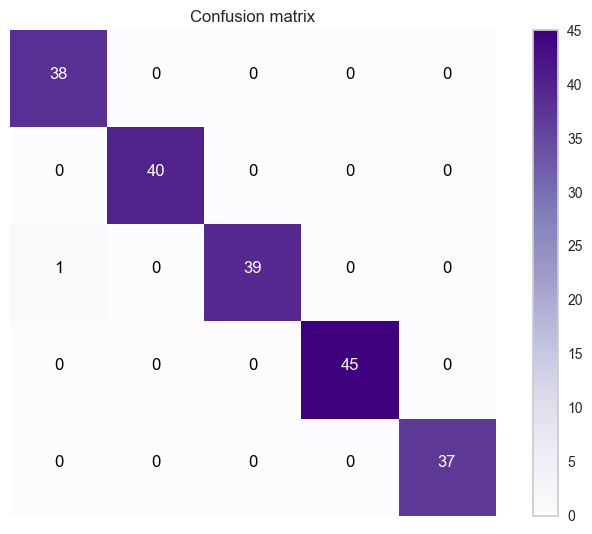

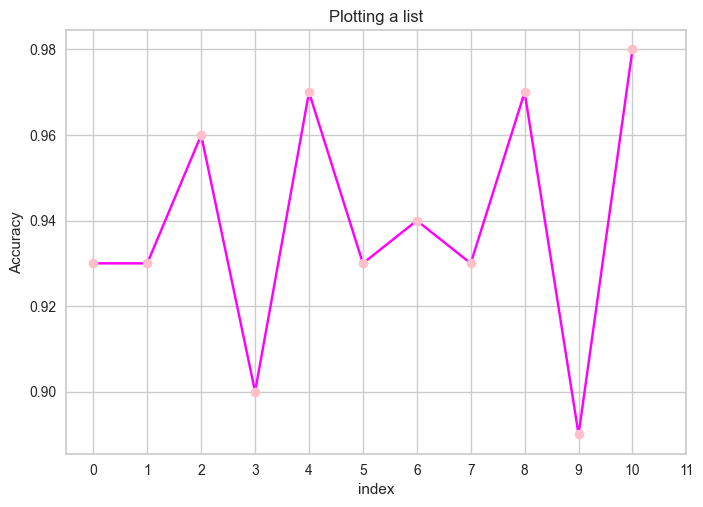

[0.93, 0.93, 0.96, 0.9, 0.97, 0.93, 0.94, 0.93, 0.97, 0.89, 0.98]


In [ ]:
Result_from_sgd_ngram= train_test_model(sgd,ngram_vectors,Y,number_of_kfold = 10)

In [ ]:
Result_from_sgd_ngram

[0.93, 0.93, 0.96, 0.9, 0.97, 0.93, 0.94, 0.93, 0.97, 0.89, 0.98]

In [ ]:
def compare_plot(title,Result_from_rfc,Result_from_nb,Result_from_xgb,Result_from_knn,Result_from_svm,Result_from_sgd):
    Algomodels = ['Random Forest','Naive Bayes','XGBoots','KNN','SVM','SGD']
    Accuracies = [Result_from_rfc[-1]*100,Result_from_nb[-1]*100,Result_from_xgb[-1]*100,Result_from_knn[-1]*100,Result_from_svm[-1]*100,Result_from_sgd[-1]*100]
    plt.figure(figsize=(10,9))
    plt.bar(Algomodels,Accuracies)
    plt.title('Model Accuracies :'+title)
    plt.ylabel('Accuracy Test')
    plt.ylim(0,100)
    plt.xticks(rotation=45)
    plt.show()

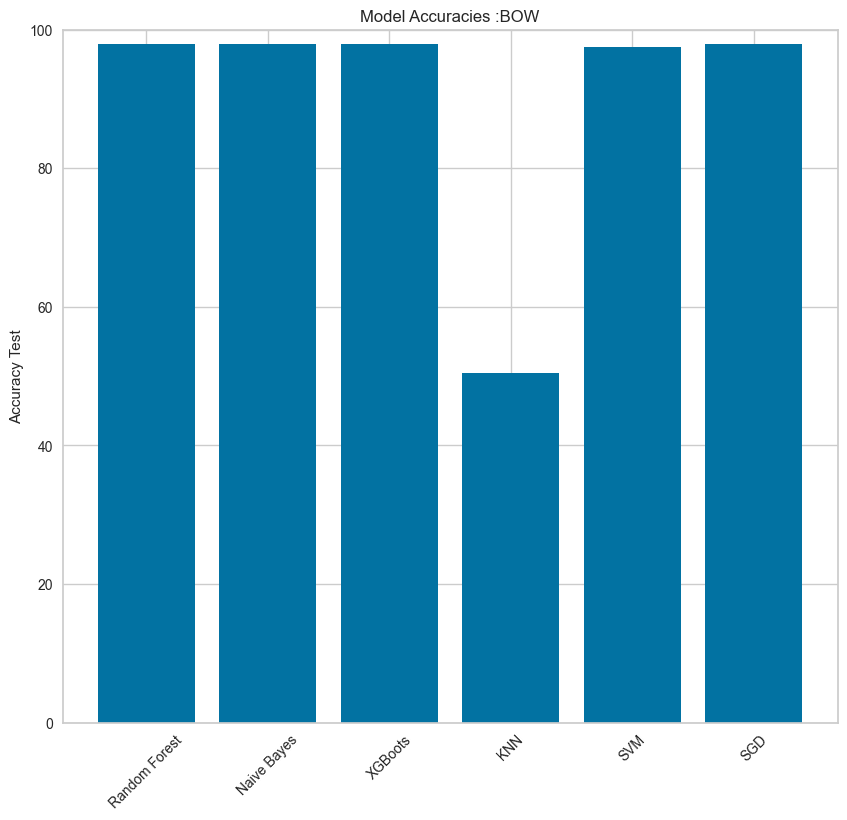

In [ ]:
compare_plot('BOW',Reslut_from_Random_Forest_Classifier_BOW,Reslut_from_Naive_Bayes_BOW,Reslut_from_xgb_BOW,Reslut_from_KNN_BOW,Result_from_svm_BOW,Result_from_sgd_BOW)

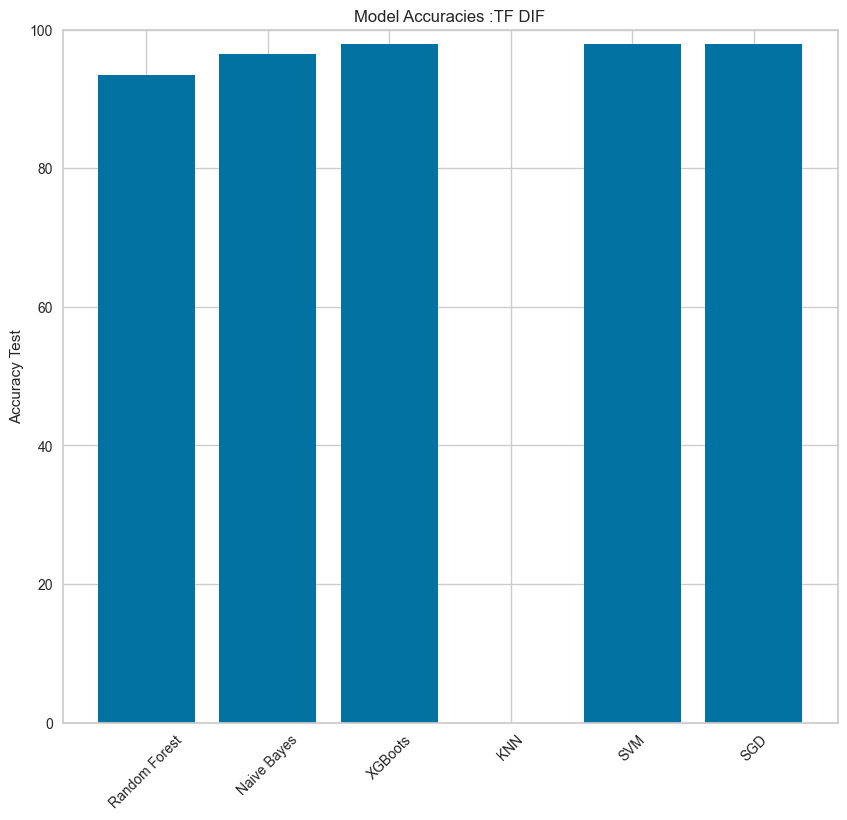

In [ ]:
compare_plot('TF DIF',Reslut_from_Random_Forest_Classifier_TF_IDF,Reslut_from_Naive_Bayes_tfidf,Reslut_from_xgb_tf_idf,Reslut_from_KNN_Tf_idf,Result_from_svm_tf_idf,Result_from_sgd_tf_idf)


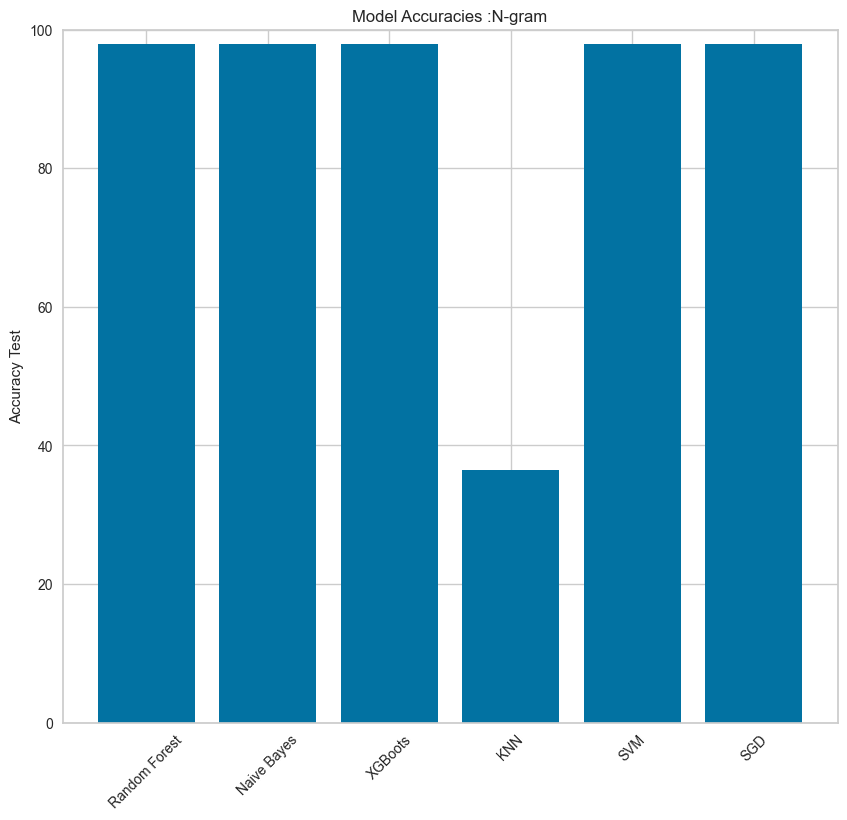

In [ ]:
compare_plot('N-gram',Reslut_from_Random_Forest_Classifier_Ngram,Reslut_from_Naive_Bayes_ngram,Reslut_from_xgb_ngram,Reslut_from_KNN_Ngram,Result_from_svm_ngram,Result_from_sgd_ngram)
